In [1]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import *
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [108]:
n_epochs = 20
batch_size_train = 64
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5


In [109]:
Trans=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
train_set = torchvision.datasets.MNIST(root='mnist_data', train=True, download=True,
                             transform=Trans)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle = True)

test_set = torchvision.datasets.MNIST(root='mnist_data', train=False, download=True,
                             transform=Trans)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle = False)

In [110]:
training_data = enumerate(train_loader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Text(0.5, 1.0, 'label 1')

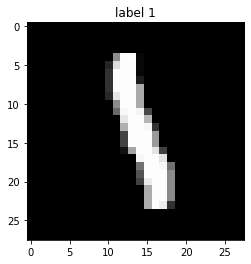

In [111]:
fig = plt.figure()
plt.imshow(images[62][0], cmap='gray')
plt.title("label {}".format(labels[62]))

In [112]:
class myCNN(nn.Module):
    def __init__(self,kernelSize):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,kernel_size=kernelSize)
        self.pool = nn.MaxPool2d(kernel_size=kernelSize)
        self.fc1 = nn.Linear(in_features=6*6*6, out_features=128)          
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.output = nn.Linear(64, 10)
      
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 6*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x 

#     def forward(self, x):
#         # I filled in the first two layers
#         # do first x=self.conv1(x)
#         self.features=F.relu(self.conv1(x))
#         x = self.pool(self.features)
#         #we need to flatten the whole thing
# #         a = x.view(-1, numpy.product(x.shape))
# #         x = x.view(x.size(0),-1)
#         x = x.view(-1, 32*13*13)
#         a = self.fc1(x)
#         a = F.relu(a)
# #         x = F.relu(self.fc1(x))
#         a = self.fc2(a)
# #         a = F.log_softmax(a,dim=1)
# #         a = self.output(a)
#         #code is missing here!
#         return a

In [113]:
model = myCNN(2) 
model

myCNN(
  (conv1): Conv2d(1, 6, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [114]:
def train_test():
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    train_acc = []
    train_final_acc = []
    test_acc = []
    train_counter=[]

    epochs = 4
    test_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    for e in range(epochs):

        train_cor = 0.0 
        train_b_l = 0.0
        train_e_l = 0.0
        val_cor = 0.0
        val_e_l = 0.0

        for batch_idx, data in enumerate(train_loader, start=1):
            inputs = data[0]
            labels = data[1]
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            train_b_l += loss.item()

            train_cor += (preds == labels).sum().item()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.2f}'.format(
                        e + 1 , 
                        batch_idx * len(data[0]), 
                        len(train_loader.dataset),
                        100.* batch_idx * len(data[0]) / len(train_loader.dataset), 
                        train_b_l / 100 ))
                train_counter.append(
                 (batch_idx*64) + ((epochs)*len(train_loader.dataset)))
                tr_acc= 100.* batch_idx * len(data[0]) / len(train_loader.dataset)
                train_acc.append(tr_acc)
               
                train_e_l += train_b_l
              
                train_b_l = 0.0
        else:
            with torch.no_grad():
                for val_data in test_loader:
                    val_inputs = val_data[0]
                    val_labels = val_data[1]
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs, val_labels)

                    _, val_preds = torch.max(val_outputs, 1)
                    val_e_l += val_loss.item()
                    val_cor += (val_preds == val_labels).sum().item()


            train_acc = 100. * train_cor / len(train_loader.dataset)
            train_f_acc.append(train_acc)
            train_e_l /= batch_idx

            val_acc = 100. * val_cor / len(test_loader.dataset)
            test_acc.append(val_acc)
            val_e_l /= batch_idx

            print('Test set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.2f}'.format(
                    val_cor, len(test_loader.dataset),
                    val_acc, val_e_l))
    return train_f_acc, test_acc

The above Train_test function calculates my accuracy and loss

Train Epoch: 1 [6400/60000 (11%)] Loss: 0.76
Train Epoch: 1 [12800/60000 (21%)] Loss: 0.31
Train Epoch: 1 [19200/60000 (32%)] Loss: 0.25
Train Epoch: 1 [25600/60000 (43%)] Loss: 0.21
Train Epoch: 1 [32000/60000 (53%)] Loss: 0.17
Train Epoch: 1 [38400/60000 (64%)] Loss: 0.17
Train Epoch: 1 [44800/60000 (75%)] Loss: 0.15
Train Epoch: 1 [51200/60000 (85%)] Loss: 0.15
Train Epoch: 1 [57600/60000 (96%)] Loss: 0.13
Test set: Accuracy: 9535.0/10000 (95%), Average Loss: 0.02
Train Epoch: 2 [6400/60000 (11%)] Loss: 0.13
Train Epoch: 2 [12800/60000 (21%)] Loss: 0.12
Train Epoch: 2 [19200/60000 (32%)] Loss: 0.11
Train Epoch: 2 [25600/60000 (43%)] Loss: 0.12
Train Epoch: 2 [32000/60000 (53%)] Loss: 0.12
Train Epoch: 2 [38400/60000 (64%)] Loss: 0.12
Train Epoch: 2 [44800/60000 (75%)] Loss: 0.12
Train Epoch: 2 [51200/60000 (85%)] Loss: 0.13
Train Epoch: 2 [57600/60000 (96%)] Loss: 0.12
Test set: Accuracy: 9676.0/10000 (97%), Average Loss: 0.01
Train Epoch: 3 [6400/60000 (11%)] Loss: 0.10
Train Epoch

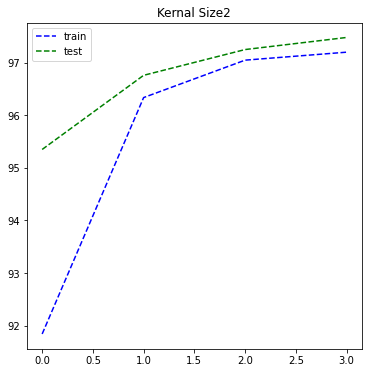

In [106]:
kernelSizes=[2]

for kernelSize in kernelSizes:
    model = myCNN(kernelSize)
    trainAccuracy, testAccuracy = train_test()
    fig = plt.figure(figsize=(6,6))
    row = len(kernelSizes)
    column = 1
    subcnt = 4
    for i in range(1,2):
        plt.subplot(row, column, i)
        plt.title("Kernal Size"+str(kernelSize))
        plt.plot(trainAccuracy,'b--',label='train')
        plt.plot(testAccuracy,'g--',label='test')
        plt.legend()

Train Epoch: 1 [6400/60000 (11%)] Loss: 0.54
Train Epoch: 1 [12800/60000 (21%)] Loss: 0.19
Train Epoch: 1 [19200/60000 (32%)] Loss: 0.17
Train Epoch: 1 [25600/60000 (43%)] Loss: 0.14
Train Epoch: 1 [32000/60000 (53%)] Loss: 0.13
Train Epoch: 1 [38400/60000 (64%)] Loss: 0.12
Train Epoch: 1 [44800/60000 (75%)] Loss: 0.11
Train Epoch: 1 [51200/60000 (85%)] Loss: 0.12
Train Epoch: 1 [57600/60000 (96%)] Loss: 0.11
Test set: Accuracy: 9709.0/10000 (97%), Average Loss: 0.01
Train Epoch: 2 [6400/60000 (11%)] Loss: 0.09
Train Epoch: 2 [12800/60000 (21%)] Loss: 0.10
Train Epoch: 2 [19200/60000 (32%)] Loss: 0.10
Train Epoch: 2 [25600/60000 (43%)] Loss: 0.08
Train Epoch: 2 [32000/60000 (53%)] Loss: 0.09
Train Epoch: 2 [38400/60000 (64%)] Loss: 0.09
Train Epoch: 2 [44800/60000 (75%)] Loss: 0.10
Train Epoch: 2 [51200/60000 (85%)] Loss: 0.10
Train Epoch: 2 [57600/60000 (96%)] Loss: 0.09
Test set: Accuracy: 9752.0/10000 (98%), Average Loss: 0.01
Train Epoch: 3 [6400/60000 (11%)] Loss: 0.07
Train Epoch

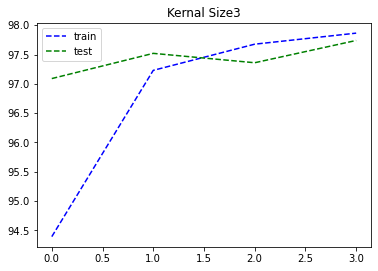

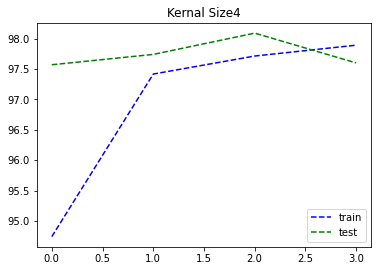

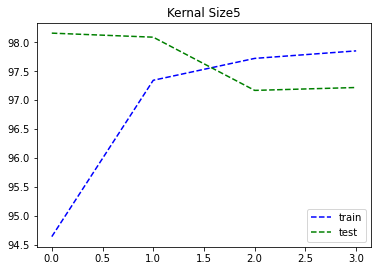

In [117]:
kernelSizes=[3,4,5]

for kernelSize in kernelSizes:
    model = myCNN(kernelSize)
    trainAccuracy, testAccuracy = train_test()
    fig = plt.figure(figsize=(6,14))
    row = len(kernelSizes)
    column = 1
    subcnt = 4
    for i in range(1,2):
        plt.subplot(row, column, i)
        plt.title("Kernal Size"+str(kernelSize))
        plt.plot(trainAccuracy,'b--',label='train')
        plt.plot(testAccuracy,'g--',label='test')
        plt.legend()

I felt its better to have the kernel size as  4 which gave the best output for the fever epochs as we increase the kernel size the model is getting to be over fitted and loosing the accuracy.